# Data description & Problem statement: 
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The type of dataset and problem is a classic supervised binary classification. Given a number of elements all with certain characteristics (features), we want to build a machine learning model to identify people affected by type 2 diabetes.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial SVM model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of SVM model: Find the best SVM model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best SVM model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [3]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/pima-indian-diabetes/indians-diabetes.csv') 
# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.columns=['NP', 'GC', 'BP', 'ST', 'I',  'BMI', 'PF', 'Age', 'Class']
df.head()

,NP,GC,BP,ST,I,BMI,PF,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
NP       768 non-null int64
GC       768 non-null int64
BP       768 non-null int64
ST       768 non-null int64
I        768 non-null int64
BMI      768 non-null float64
PF       768 non-null float64
Age      768 non-null int64
Class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df['ST'].replace(0, df[df['ST']!=0]['ST'].mean(), inplace=True)
df['GC'].replace(0, df[df['GC']!=0]['GC'].mean(), inplace=True)
df['BP'].replace(0, df[df['BP']!=0]['BP'].mean(), inplace=True)
df['BMI'].replace(0, df[df['BMI']!=0]['BMI'].mean(), inplace=True)
df['I'].replace(0, df[df['I']!=0]['I'].mean(), inplace=True)

In [6]:
X=df.drop('Class', axis=1)
y=df['Class']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalor_X=MinMaxScaler().fit(X_train)
X_train=scalor_X.transform(X_train)
X_test=scalor_X.transform(X_test)

In [8]:
# We build the Initial Model & Cross-Validation:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=SVC(C=10, gamma=0.1,  random_state=42)
kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.81809211 0.83585526 0.852      0.87166667 0.85401709] 

Accuracy: 0.85 (+/- 0.02)


In [9]:
# Grid-Serach for the best model parameters: 

# Rough Search (Round 1)
from sklearn.model_selection import GridSearchCV

param={'kernel':['rbf'], 'C': [0.1, 0.5, 1, 2, 3,  6, 10, 50, 100, 300], 'gamma':[0.001, 0.01, 0.1, 0.5, 1, 2]}

kfold=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid_search=GridSearchCV(SVC(class_weight='balanced'), param, cv=kfold, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
56,0.011532,0.000953,0.002356,0.000412,300,0.1,rbf,"{'C': 300, 'gamma': 0.1, 'kernel': 'rbf'}",0.839158,0.852553,...,0.857143,0.852874,0.008739,1,0.889000,0.882444,0.887353,0.888433,0.886807,0.002588
50,0.009920,0.001359,0.002356,0.000215,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.834737,0.866809,...,0.846939,0.852153,0.012371,2,0.881289,0.875305,0.879859,0.879223,0.878919,0.002216
15,0.009052,0.002514,0.002480,0.000350,1,0.5,rbf,"{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}",0.828211,0.878723,...,0.841945,0.851239,0.018705,3,0.869746,0.861076,0.865084,0.863628,0.864884,0.003153


In [10]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'C': 300, 'gamma': 0.1, 'kernel': 'rbf'}
Best validation accuracy:  0.85 (+/- 0.01)
Test score:  0.8


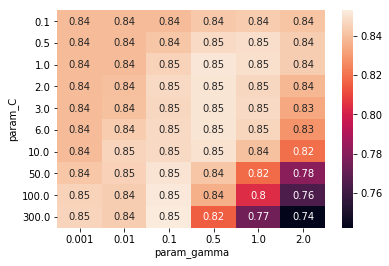

In [11]:
h=G[["param_C", "param_gamma", "mean_test_score"]].pivot_table(index="param_C", columns="param_gamma", values="mean_test_score")
sns.heatmap(h, annot=True)

Confusion matrix, without normalization
[[83 40]
 [15 54]]
Normalized confusion matrix
[[0.67 0.33]
 [0.22 0.78]]


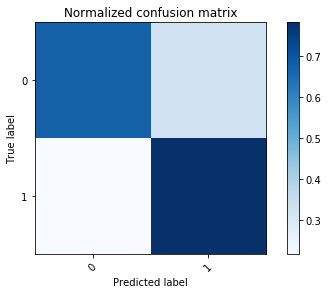

In [12]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [13]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.85      0.67      0.75       123
          1       0.57      0.78      0.66        69

avg / total       0.75      0.71      0.72       192



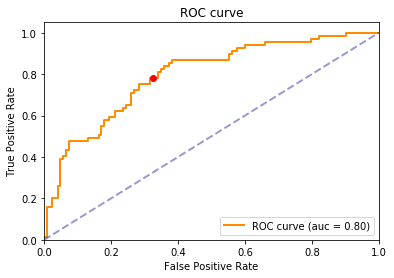

In [14]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test), grid_search.decision_function(X_test) , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.decision_function(X_test))

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

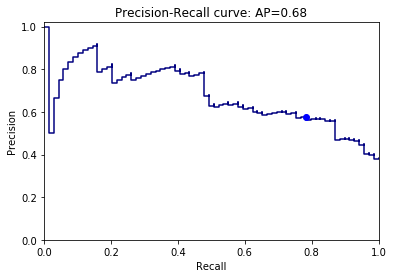

In [15]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.decision_function(X_test),  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.decision_function(X_test))

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()